In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

from ml.utils.estimating import model_estimator
from ml.utils.preprocessing import PreProcessor

import warnings
warnings.simplefilter("ignore")

In [2]:
def get_ticker_daily_close(ticker = "AAPL"):
    """ returns the daily close price for a maximum period for specified ticker """
    import yfinance
    
    tick = yfinance.Ticker(ticker)
    return tick.history(period = "max", interval = "1d")["Close"]

### Process Data to Features and Targets Tensors

In [10]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("MSFT")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for neural network (lagged input)
df = pd.DataFrame({})
lags = 20
for i in range(1, lags+1):
    df[f"lag_{i}"] = targets.shift(i)

# features for HAR (realized daily/weekly/monthly volatility)
df_har = pd.DataFrame({})
df_har["rv_d"] = targets.shift(1)
df_har["rv_w"] = targets.rolling(5).apply(np.mean)
df_har["rv_m"] = targets.rolling(20).apply(np.mean)
    
# features and targets to numpy array
features_har = df_har.values
features = df.values
targets = targets.values.reshape(-1,1)

# drop nan values
features = features_har.copy()

features_har = sm.add_constant(features_har)
features_har = features_har[lags+1:-max(1, int(.3*lags))]
features = features[lags+1:-max(1, int(.3*lags))]
targets = targets[lags+1:-max(1, int(.3*lags))]

print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

Total observations: 9286
shape har featurs: (9259, 4) of type <class 'numpy.ndarray'>
shape nn features: (9259, 3) of type <class 'numpy.ndarray'>
shape targets: (9259, 1) of type <class 'numpy.ndarray'>


In [11]:
def print_nicely(note, length):
    note = f"Estimating HAR and NN for fold: {i}"
    length = 100
    l = int((length-len(note))/2)
    m = length - l - len(note)
    print("="*length)
    print(l*"=" + note + m*"=")
    print("="*length)

### Define Neural Network

In [15]:
class RecurrentNeuralNetwork(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, lags, hidden_dim = 1, n_layers = 1, output_size = 1):
        # initialize nn.Module
        super(RecurrentNeuralNetwork, self).__init__()
        
        # store model specifications
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # initialize layers
        self.rn = nn.RNN(lags, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """
        x = x.unsqueeze(0)
        batch_size = x.size(0)
        
        hidden = self.init_hidden(batch_size)
        x, hidden = self.rn(x, hidden)
        x = x.contiguous().view(-1, self.hidden_dim)
        
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        
class RegularNN(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, input_size, hidden_nodes: int = 10, output_size = 1):
        # initialize nn.Module
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_nodes, bias = False)
        self.fc2 = nn.Linear(hidden_nodes, 1, bias = False)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """             
        x = torch.flatten(x,1)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### Compare Neural Network VS HAR

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


=================================Estimating HAR and NN for fold: 1==================================
Normalizing features ...
Estimating HAR model ...
HAR out-of-sample loss: 7.419196686951896e-07


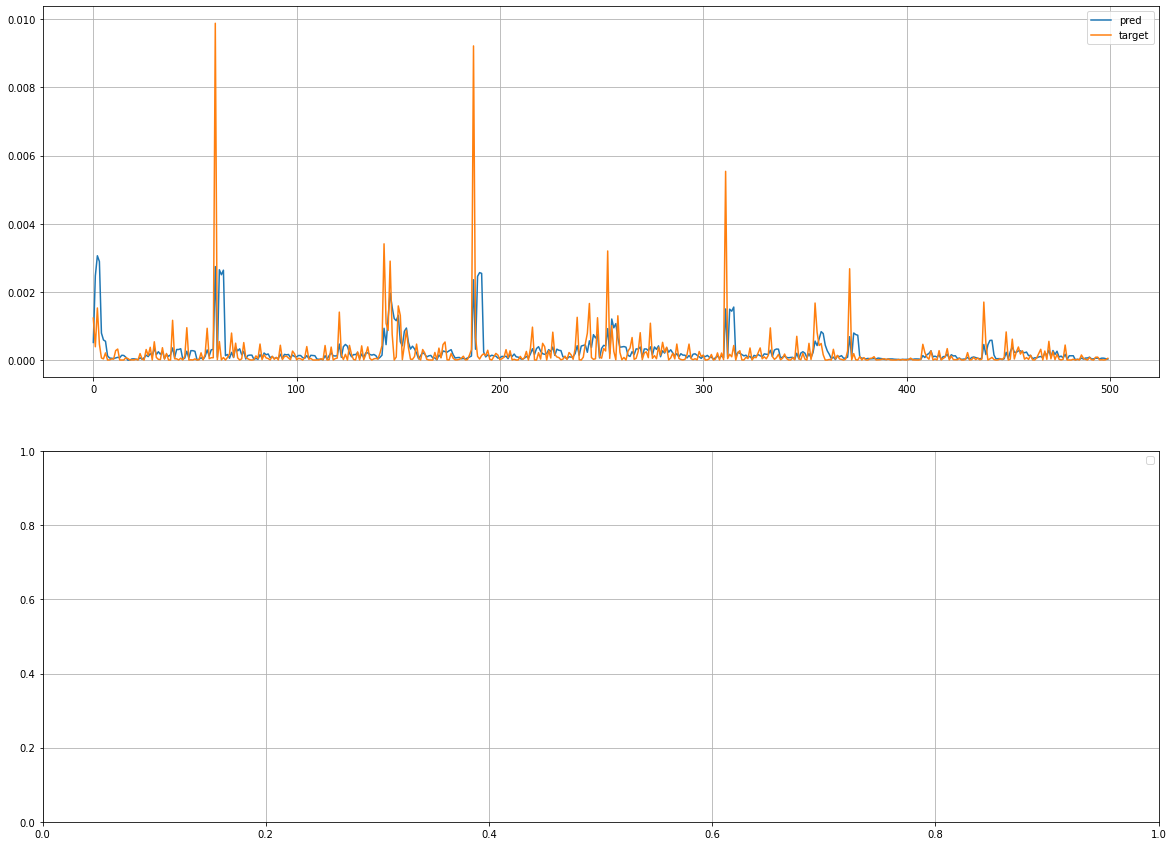

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


=================================Estimating HAR and NN for fold: 2==================================
Normalizing features ...
Estimating HAR model ...
HAR out-of-sample loss: 3.7787067629831563e-07


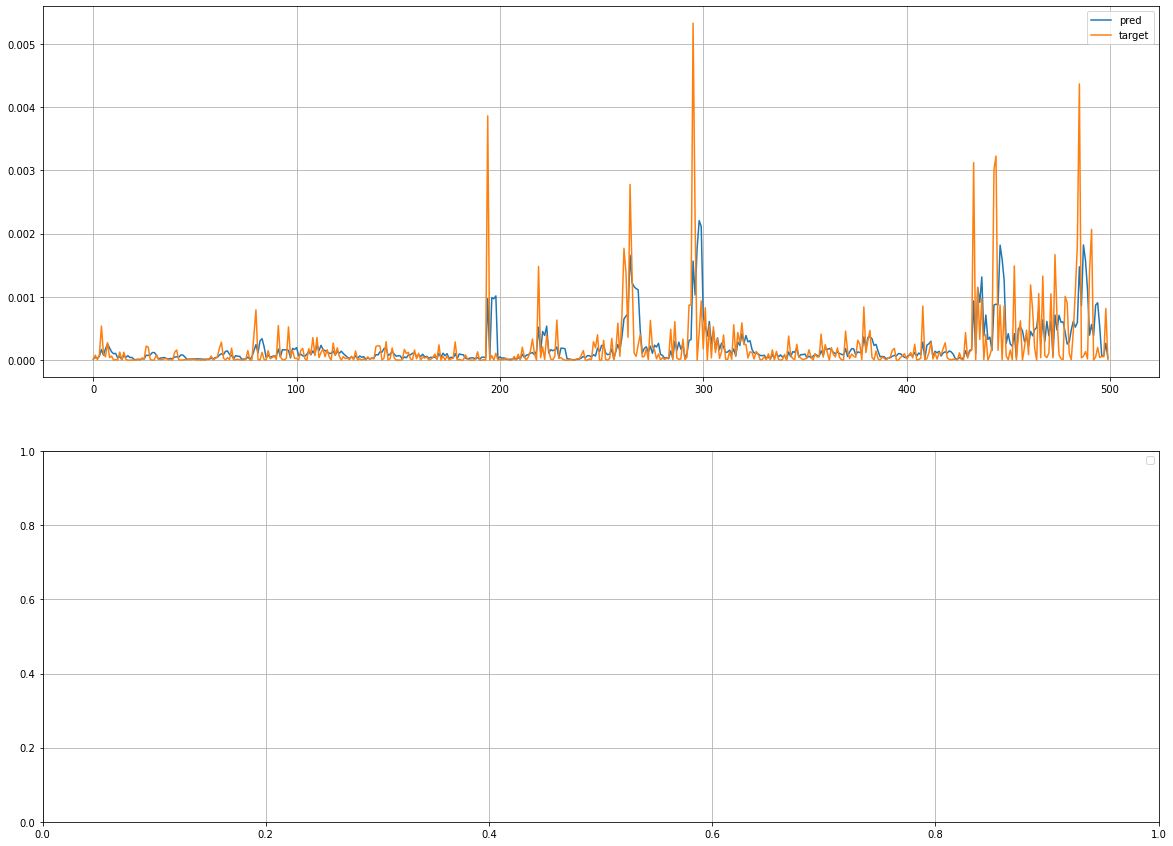

=================================Estimating HAR and NN for fold: 3==================================
Normalizing features ...
Estimating HAR model ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


HAR out-of-sample loss: 4.1813684126560495e-06


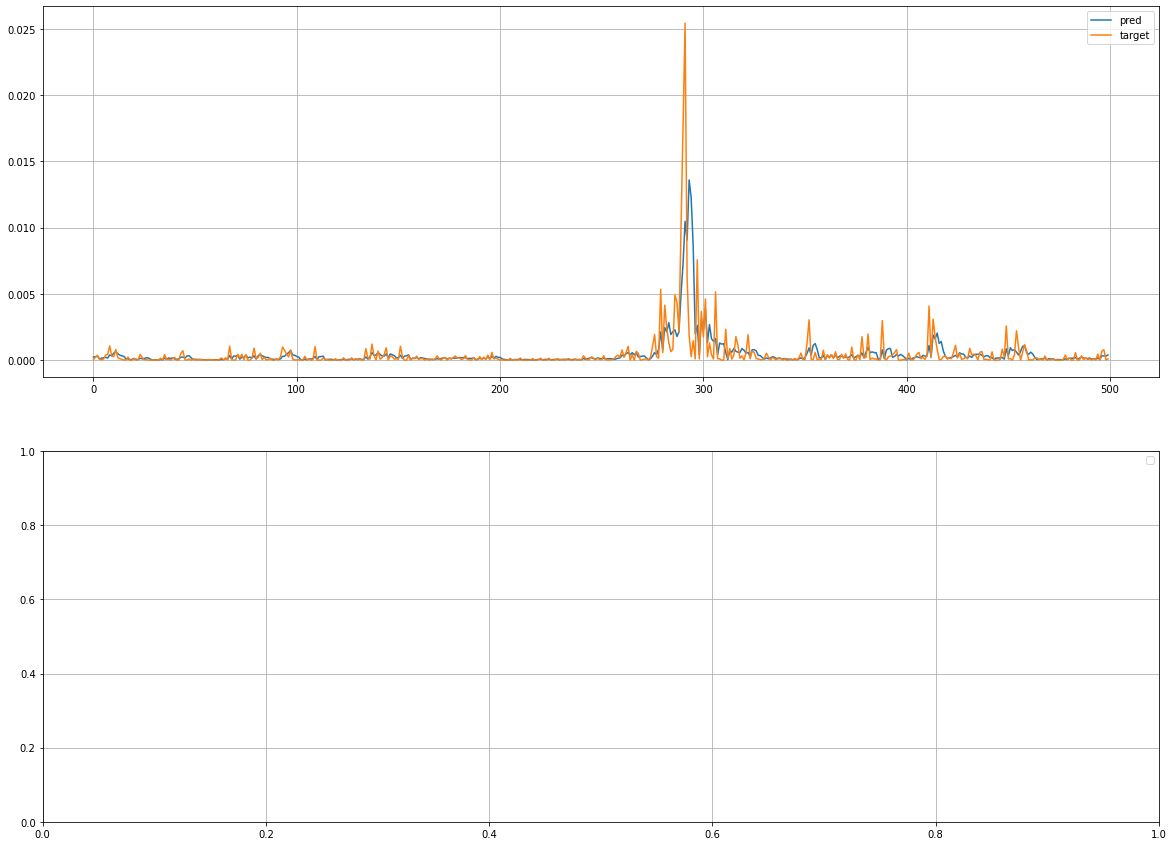

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


=================================Estimating HAR and NN for fold: 4==================================
Normalizing features ...
Estimating HAR model ...
HAR out-of-sample loss: 5.181520291548391e-07


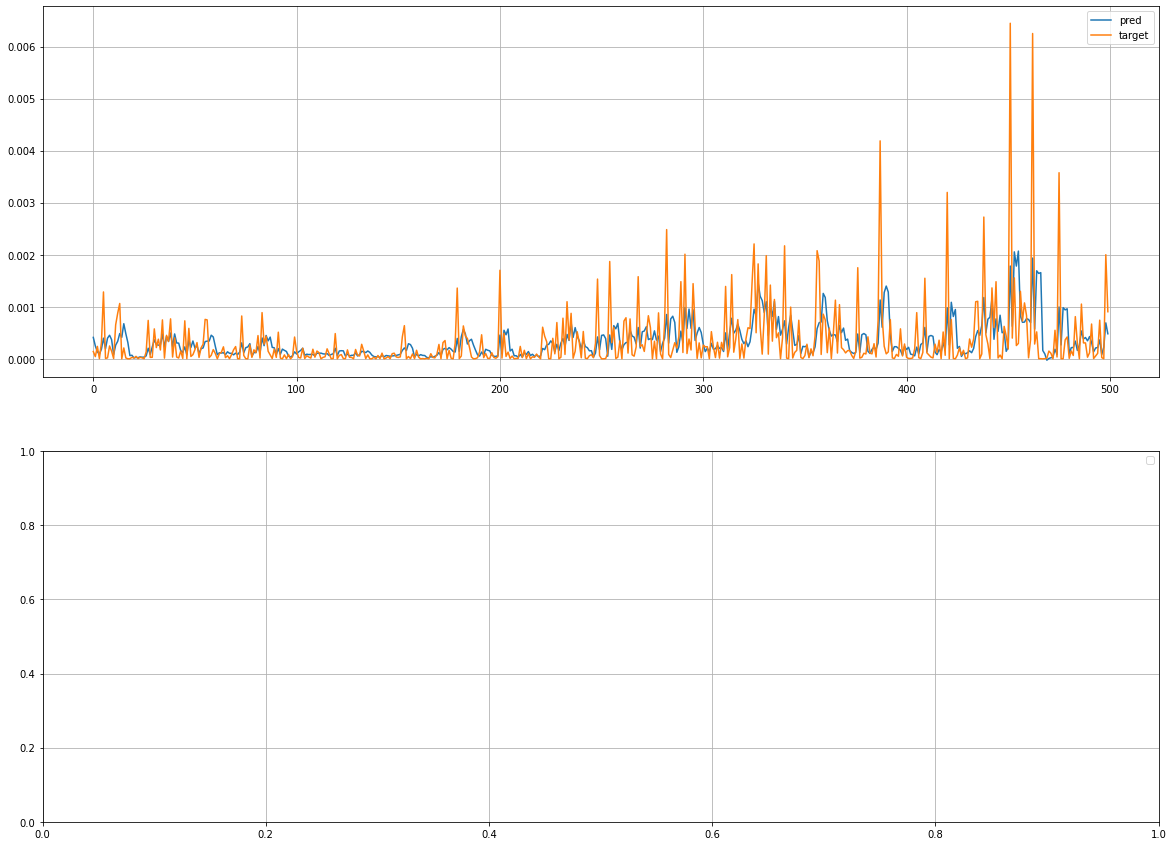

=================================Estimating HAR and NN for fold: 4==================================
Average HAR MSE Loss: 1.4548276967010984e-06
Average NN MSE Loss: nan


In [18]:
plot = True

model_specifications = ((1,),)
for model_specification in model_specifications:

    score_nn = []
    score_har = []
    
    kfold = TimeSeriesSplit(n_splits = 4, max_train_size = 6000, test_size = 500)
    
    i = 0
    for train_index, test_index in kfold.split(features):
        i += 1
        
        note = f"Estimating HAR and NN for fold: {i}"
        print_nicely(note, 100)
        
        if plot:
            fig, axs = plt.subplots(2,1, figsize = (20, 15))
        
        # split data into feature and target data
        features_train, features_test, targets_train, targets_test = \
            features[train_index], features[test_index], targets[train_index], targets[test_index]
            
        features_train_har, features_test_har = features_har[train_index], features_har[test_index]
        
        # fit normalizer on train features and normalize data
        print("Normalizing features ...")
        scaler = StandardScaler()
        features_train = scaler.fit_transform(features_train)
        features_test = scaler.transform(features_test)

        #=========================================================================================
        #===================================ESTIMATE HAR==========================================
        #=========================================================================================
        print("Estimating HAR model ...")
        
        mod = OLS(targets_train, features_train_har, hasconst = True)
        mod = mod.fit()
        output = mod.predict(features_test_har)

        if plot:        
            # plot prediction versus true daily volatility
            axs[0].plot(output, label = "pred")
            axs[0].plot(targets_test, label = "target")
        
        loss = np.var(targets_test - output)
        score_har += [loss]
        
        print(f"HAR out-of-sample loss: {loss}")

        #=========================================================================================
        #====================================ESTIMATE NN==========================================
        #=========================================================================================
        # all features and targets to float tensor
        features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
        features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
        targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32)
        targets_test_tensor = torch.tensor(targets_test, dtype=torch.float32)

        # to data loader so torch can handle the data efficiently
        trainloader = torch.utils.data.DataLoader( 
            [(feature, target) for feature, target in zip(features_train_tensor, targets_train_tensor)], 
            batch_size = 20)
                
        # initialize and estimate the model
        print("Estimating NN model ...")
        model = RegularNN(3, hidden_nodes=20)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr = .01)
        epochs = 50
        
        model_estimator(
            model,
            optimizer, 
            criterion, 
            epochs,
            trainloader, 
            testloader=None)
        
        # perform out of sample
        output = model(features_test_tensor)
        
        if plot:
            # plot prediction versus true daily volatility
            axs[1].plot(output.detach().numpy(), label = "pred")
            axs[1].plot(targets_test_tensor.detach().numpy(), label = "target")
        
        # first method
        loss = criterion(output, targets_test_tensor)
        score_nn += [loss.item()]
        
        print(f"NN out-of-sample loss: {loss}")
        
        #=========================================================================================
        #=========================================================================================
        #=========================================================================================

        if plot:        
            for ax in axs:
                ax.legend()
                ax.grid()
            plt.show()

    avg_score_nn = np.average(score_nn)
    avg_score_har = np.average(score_har)
    
    print_nicely("Final Results NN and HAR Model", 100)
    print(f"Average HAR MSE Loss: {avg_score_har}")
    print(f"Average NN MSE Loss: {avg_score_nn}")